In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import matplotlib.image as image

import sys
sys.path.append('./')
from utils import Dummyfier, prepare, evaluate_clf, uplift

from IPython.core.debugger import set_trace

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
train = pd.read_csv('./train_data/train_dataset.csv', sep='>', na_values='<null>', 
                 parse_dates=['START_DATE', 'LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE'])
print('Dataset size: ', train.shape)
train.head(2)

Dataset size:  (114720, 215)


,CONTRACT_REF,CLIENT_ID,CONTROL_GROUP_FLG,START_DATE,TARGET,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,273-P-99431598,105098373,N,2017-01-23,1,ГОРЯЧИЙКЛЮЧ,RU,ГОРЯЧИЙКЛЮЧ,RU,КАМЫШИН,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,274-P-23967129,101763714,N,2017-04-08,1,МУРМАНСК,RU,МУРМАНСК,RU,АХТУБИНСК,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
set(train.columns.tolist()) - set(test.columns.tolist())

{'CONTROL_GROUP_FLG', 'SCENARIO_NAME_UNI', 'TARGET'}

In [4]:
#test =  pd.read_csv('./test_data_04_2018/test_04_2018.csv/CD_ALL_2018-03-30.csv', sep='>', na_values='<null>', 
#                     parse_dates=['LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT'], encoding='latin-1')
test = pd.read_csv('test_data/test_data_05_2018/test_data_05_2018.csv', sep='>', na_values='<null>', 
                 parse_dates=['LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE'])
print('Dataset size: ', test.shape)
test.head(2)
#test = test.set_index(['CONTRACT_REF', 'CLIENT_ID'])

Dataset size:  (79544, 212)


,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,13_AddrCountry,BAL,BANK,BIRTH_DATE,CARD_CONTR_COUNT_0,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,0.0,0.0,0.0,0.0,0.0,0.0,304.83,BBKK,1989-02-03,3,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,BBKK,NaT,1,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [21]:
# Some features to check 
test_data_check = test[['CLIENT_ID', 'CONTRACT_REF', 
                        'BIRTH_DATE','CL_INDUSTR','REP_POPULATION',
                        'FL_GOLD', 'REP_SEX',
                        'BAL',
                        #'TOTAL_MAX_180', 'TOTAL_N_180',
                        'LIM_RECENT', 
                        'LAST_CARD_STATUS_DT','LAST_CONTR_STATUS_DT','LAST_CARD_STATUS']]
print(.shape)
#print(np.mean(test_data_check['TOTAL_MAX_180']))
#print(np.mean(test_data_check['BAL']) )
#test_data_check.to_csv('./test_data_04_2018/check_test_data_02_04_2018_v2.csv', index=False)

(79544, 12)


In [29]:
test_data_check.head()

,CLIENT_ID,CONTRACT_REF,BIRTH_DATE,CL_INDUSTR,REP_POPULATION,FL_GOLD,REP_SEX,BAL,LIM_RECENT,LAST_CARD_STATUS_DT,LAST_CONTR_STATUS_DT,LAST_CARD_STATUS
0,101947485,271-P-00303161,0.0,SERVICESECTOR,511000.0,N,M,304.83,160000.0,2017-09-13 17:52:03,2016-02-21 18:51:55,14
1,105173333,271-P-00687159,0.0,RUR,21326.0,Y,F,0.00,150000.0,2016-02-24 22:43:42,2016-02-21 20:00:39,14
2,101863520,271-P-00559853,0.0,FULLWORK,NaN,N,M,0.00,30000.0,2018-01-17 13:17:26,2016-02-22 10:34:02,14
3,101839082,271-P-02328844,0.0,RUR,28937.0,Y,M,670.22,150000.0,2018-02-20 15:51:28,2016-02-21 18:52:26,14
4,101737216,271-P-02926365,0.0,N,NaN,Y,F,-55474.52,150000.0,2017-10-05 13:16:31,2016-02-21 22:17:01,98


In [5]:
train = pd.read_csv('./train_data/train_dataset.csv', sep='>', na_values='<null>', 
                 parse_dates=['START_DATE', 'LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE'])
print('Dataset size: ', train.shape)
train.head(2)

Dataset size:  (114720, 215)


,CONTRACT_REF,CLIENT_ID,CONTROL_GROUP_FLG,START_DATE,TARGET,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,273-P-99431598,105098373,N,2017-01-23,1,ГОРЯЧИЙКЛЮЧ,RU,ГОРЯЧИЙКЛЮЧ,RU,КАМЫШИН,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,274-P-23967129,101763714,N,2017-04-08,1,МУРМАНСК,RU,МУРМАНСК,RU,АХТУБИНСК,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
#train[ ['START_DATE', 'LAST_CARD_STATUS_DT', 'LAST_CARD_STATUS_DT_N']].head(20)

In [22]:
# test START_DATE HAS str type
test['START_DATE'] = pd.to_datetime(test['START_DATE'])

In [14]:
test['START_DATE'].values

array(['2018-04-26T00:00:00.000000000', '2018-04-26T00:00:00.000000000',
       '2018-04-26T00:00:00.000000000', ...,
       '2018-04-26T00:00:00.000000000', '2018-04-26T00:00:00.000000000',
       '2018-04-26T00:00:00.000000000'], dtype='datetime64[ns]')

In [17]:
# test START_DATE is set in test process script
train = train.assign( LAST_CARD_STATUS_DT_N =  (train['START_DATE'] - train['LAST_CARD_STATUS_DT']).dt.days)
train = train.assign( LAST_CONTR_STATUS_DT_N =  (train['START_DATE'] - train['LAST_CONTR_STATUS_DT']).dt.days)
test = test.assign( LAST_CARD_STATUS_DT_N =  (pd.to_datetime(test['START_DATE']) - test['LAST_CARD_STATUS_DT']).dt.days)
test = test.assign( LAST_CONTR_STATUS_DT_N =  (pd.to_datetime(test['START_DATE']) - test['LAST_CONTR_STATUS_DT']).dt.days)

In [18]:
dummy = [u'CL_FAM_ST', u'CL_OFF_POS', u'CL_OWN_TYPE', u'LAST_CARD_STATUS', 'CL_ESTATE_TYPE', 
         'CL_INDUSTR', 'CL_SOC_ST', 'ZODIAC']

d = Dummyfier(dummy, drop_old=True)

Xy_train = prepare(train)
Xy_train = d.fit_transform(Xy_train)

na_cols_train = Xy_train.isna().any()
na_cols_train = na_cols_train[na_cols_train==True].index.tolist()
Xy_train = Xy_train.fillna(value=Xy_train[na_cols_train].mean())

y_train = Xy_train['TARGET'].values.flatten()

identity = ['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME_UNI', 'START_DATE']
#X_train = Xy_train.drop(['TARGET'] + identity, axis=1)

In [21]:
Xy_train.head()

,CONTRACT_REF,CLIENT_ID,CONTROL_GROUP_FLG,START_DATE,TARGET,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,...,ZODIAC_dummy_Virgo,ZODIAC_dummy_Pices,ZODIAC_dummy_Aries,ZODIAC_dummy_Aquarium,ZODIAC_dummy_Sagittarius,ZODIAC_dummy_Gemini,ZODIAC_dummy_Taurus,ZODIAC_dummy_Scorpio,ZODIAC_dummy_Capricorn,ZODIAC_dummy_Libra
0,273-P-99431598,105098373,0,2017-01-23,1,ГОРЯЧИЙКЛЮЧ,RU,ГОРЯЧИЙКЛЮЧ,RU,КАМЫШИН,...,0,0,0,0,1,0,0,0,0,0
1,274-P-23967129,101763714,0,2017-04-08,1,МУРМАНСК,RU,МУРМАНСК,RU,АХТУБИНСК,...,0,0,0,0,0,0,0,0,0,0
2,274-P-67223249,104216626,0,2017-01-23,1,СОСНОВЫЙБОР,RU,СОСНОВЫЙБОР,RU,ВЕРХНИЕРУДИЦЫ,...,0,0,0,0,0,0,1,0,0,0
3,273-P-51055302,102113400,0,2016-12-15,1,РОСТОВНАДОНУ,RU,РОСТОВНАДОНУ,RU,РОСТОВНАДОНУ,...,0,0,0,0,0,0,1,0,0,0
4,271-P-09670370,101989621,0,2017-01-19,1,ЛИПЕЦК,RU,ЛИПЕЦК,RU,СТУПИНО,...,0,0,0,0,1,0,0,0,0,0


In [60]:
test["BIRTH_DATE"]  =  pd.to_datetime('2017-01-01', format= '%Y-%m-%d')

In [66]:
test['QTY_CHLD'] = 1

In [67]:
X_test = prepare(test)
X_test = d.transform(X_test)

na_cols_test = X_test.isna().any()
na_cols_test = na_cols_test[na_cols_test==True].index.tolist()
# BAD! # Need to do use mean which calculated on train  
X_test = X_test.fillna(value=X_test[na_cols_test].mean())

X_test = X_test.drop('START_DATE', axis=1)
X_test['CONTROL_GROUP_FLG'] = 0

#X_test = X_test[X_train.columns.tolist()]

In [74]:
X_train = Xy_train.drop(['TARGET'], axis=1)
X_train = X_train.set_index(identity)
#X_test = X_test.set_index(['CLIENT_ID', 'CONTRACT_REF'])
#X_test.drop(['LAST_CARD_STATUS_dummy_63'], axis=1, inplace=True)

In [76]:
#X_test.drop(['LAST_CARD_STATUS_dummy_63'], axis=1, inplace=True)

In [ ]:
X_test.columns.tolist())

In [77]:
print(len(X_train.columns.tolist()))
print(len(X_test.columns.tolist()))

212
213


In [18]:
X_test.head(2)

,,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,13_AddrCountry,BAL,BANK,BIRTH_DATE,CARD_CONTR_COUNT_0,...,ZODIAC_dummy_Pices,ZODIAC_dummy_Aries,ZODIAC_dummy_Aquarium,ZODIAC_dummy_Sagittarius,ZODIAC_dummy_Gemini,ZODIAC_dummy_Taurus,ZODIAC_dummy_Scorpio,ZODIAC_dummy_Capricorn,ZODIAC_dummy_Libra,CONTROL_GROUP_FLG
CLIENT_ID,CONTRACT_REF,,,,,,,,,,,,,,,,,,,,,
103016707,273-P-90421929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BBKK,1952-08-16,1,...,0,0,0,1,0,0,0,0,0,0
104531162,271-P-21418527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BBKK,1956-08-17,1,...,0,0,0,1,0,0,0,0,0,0


In [80]:
X_test.drop('ZODIAC_dummy_Cancer', axis=1, inplace=True)

In [81]:
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))
print(X_train.shape)
print( round(np.mean(X_train["CONTROL_GROUP_FLG"]),4))
print( round(np.mean(y_train),4))

set()
set()
(114720, 212)
0.1506
0.0445


In [82]:
print( set(X_train.columns) == set(X_test.columns))

True


In [106]:
X_train['FL_GOLD'].value_counts().head()

0.000000    108066
0.004679      6146
1.000000       508
Name: FL_SOC, dtype: int64

In [108]:
X_test['FL_GOLD'].value_counts().head()

0.000000    44196
0.237934    21549
1.000000    13799
Name: FL_GOLD, dtype: int64

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


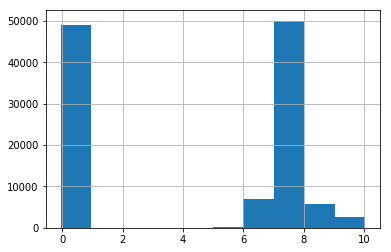

In [109]:
np.log(X_train['LIM_AVG_CHANGE'] +1).hist();

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


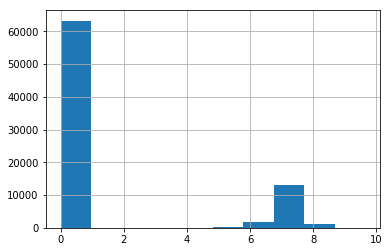

In [110]:
np.log(X_test['LIM_AVG_CHANGE'] +1).hist();

In [83]:
X_test = X_test[X_train.columns]
sum([ (X_train.columns[i] == X_test.columns[i]) for i in range(X_train.shape[1]) ]) == X_test.shape[1]

True

In [27]:
#X_train['CONTROL_GROUP_FLG'].value_counts(normalize=True)

In [118]:
losted_cols

['11_AddrCity2',
 '11_AddrCountry',
 '12_AddrCity2',
 '12_AddrCountry',
 '13_AddrCity2',
 '13_AddrCountry']

In [117]:
# Read losted in new test data cols:
with open('test_data/test_data_05_2018/test_lost_cols_list.bin', 'rb') as fp:
    losted_cols = pickle.load(fp)
#print(len(losted_cols) == 51)

In [119]:
X_train_omit = X_train[ [ x for x in X_train.columns.tolist()  if x not in  (losted_cols)]]
X_test_omit = X_test[ [ x for x in X_test.columns.tolist()  if x not in  (losted_cols)]]

In [30]:
#X_test_omit[['LAST_CARD_STATUS_DT', 'LAST_CARD_STATUS_DT_N']].sort_values('LAST_CARD_STATUS_DT_N', ascending=False).head(100)

In [120]:
tmp = pd.DataFrame(X_train_omit.dtypes, columns = ['type'])
not_numeric_cols = tmp.index[~tmp['type'].astype(str).isin(set(['int64','float64','int32'])).values]
print("Not numeric columns list:")
list(not_numeric_cols)

Not numeric columns list:


['BANK',
 'BIRTH_DATE',
 'CL_CCY_DOP',
 'CL_CCY_ZP',
 'FL_CR_PAN',
 'FL_DIR_UCH',
 'FL_STUD',
 'LAST_CARD_STATUS_DT',
 'LAST_CONTR_STATUS_DT']

In [121]:
omit_zod_cols = ['ZODIAC_dummy_Leo','ZODIAC_dummy_Virgo','ZODIAC_dummy_Pices', 'ZODIAC_dummy_Aries','ZODIAC_dummy_Aquarium', 
                 'ZODIAC_dummy_Sagittarius', 'ZODIAC_dummy_Gemini','ZODIAC_dummy_Taurus','ZODIAC_dummy_Scorpio',
                 'ZODIAC_dummy_Capricorn','ZODIAC_dummy_Libra']

omit_cols_list = ['BANK','BIRTH_DATE','CL_CCY_DOP','CL_CCY_ZP', 'FL_CR_PAN','FL_DIR_UCH','FL_STUD'] +\
                    ['LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT'] +  omit_zod_cols

X_train_omit.drop(omit_cols_list, axis=1, inplace=True)
X_test_omit.drop(omit_cols_list, axis=1, inplace=True)

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [122]:
print(X_train_omit.shape)
print(X_test_omit.shape)
print(len(y_train))

(114720, 186)
(79544, 186)
114720


In [123]:
sum([ (X_train_omit.columns[i] == X_test_omit.columns[i])*1.0 for i in range(X_train_omit.shape[1]) ]) == 186

True

In [125]:
X_train_omit.head()

,,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,CODE_17_MAX_180,...,CL_INDUSTR_dummy_TOURISM,CL_INDUSTR_dummy_LEGALSERVICES,CL_SOC_ST_dummy_FULLWORK,CL_SOC_ST_dummy_NOTWORKER,CL_SOC_ST_dummy_WORKINGPENS,CL_SOC_ST_dummy_PENSIONER,CL_SOC_ST_dummy_NA,CL_SOC_ST_dummy_DECREE,CL_SOC_ST_dummy_HALFWORKER,CL_SOC_ST_dummy_CONTRACT
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME_UNI,START_DATE,,,,,,,,,,,,,,,,,,,,,
273-P-99431598,105098373,UVEL_2,2017-01-23,0,0.00,3.0,1.0,2.0,3600.0,23500.0,0.0,11.0,0.0,...,0,0,0,0,1,0,0,0,0,0
274-P-23967129,101763714,ATM_2,2017-04-08,0,0.00,2.0,1.0,1.0,0.0,20000.0,0.0,12.0,0.0,...,0,0,0,0,0,0,0,1,0,0
274-P-67223249,104216626,UVEL_5,2017-01-23,0,407.44,3.0,1.0,2.0,0.0,31000.0,1.0,12.0,0.0,...,0,0,0,0,1,0,0,0,0,0
273-P-51055302,102113400,Sc_6,2016-12-15,0,45.05,1.0,1.0,0.0,30000.0,50000.0,0.0,16.0,0.0,...,0,0,0,0,0,0,0,0,0,0
271-P-09670370,101989621,UVEL_1,2017-01-19,0,-27803.59,1.0,1.0,0.0,2000.0,10000.0,1.0,16.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [128]:
X_test_omit.head()

,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,CODE_17_MAX_180,...,CL_INDUSTR_dummy_TOURISM,CL_INDUSTR_dummy_LEGALSERVICES,CL_SOC_ST_dummy_FULLWORK,CL_SOC_ST_dummy_NOTWORKER,CL_SOC_ST_dummy_WORKINGPENS,CL_SOC_ST_dummy_PENSIONER,CL_SOC_ST_dummy_NA,CL_SOC_ST_dummy_DECREE,CL_SOC_ST_dummy_HALFWORKER,CL_SOC_ST_dummy_CONTRACT
CLIENT_ID,CONTRACT_REF,,,,,,,,,,,,,,,,,,,,,
101947485,271-P-00303161,0,304.83,3,3.0,1.0,0,20000,1.000000,16.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
105173333,271-P-00687159,0,0.00,1,1.0,0.0,406900,N,0.268173,13.662596,0.0,...,0,0,0,0,0,0,0,0,0,0
101863520,271-P-00559853,0,0.00,2,2.0,0.0,N,RUR,0.268173,13.662596,0.0,...,0,0,0,0,0,0,0,0,0,0
101839082,271-P-02328844,0,670.22,5,7.0,4.0,0,N,0.268173,13.662596,0.0,...,0,0,0,0,0,0,0,0,0,0
101737216,271-P-02926365,0,-55474.52,4,4.0,1.0,0,NaN,0.268173,13.662596,0.0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
total_trans_cols =  ['TOTAL_MAX_180', 'TOTAL_MAX_31', 'TOTAL_MAX_90', 'TOTAL_MEAN_180', 'TOTAL_MEAN_90', 
                     'TOTAL_N_180', 'TOTAL_N_90','TOTAL_SUM_180', 'TOTAL_SUM_90']
trans_cols = [ x for x in X_train_omit.columns.tolist() if (('CODE' in x) or ('TXN_') in x)] + total_trans_cols
not_trans_cols = [ z for z in X_train_omit.columns.tolist()  if z not in trans_cols]
print(len(not_trans_cols ))

117


In [130]:
# REMOVE TRANS FEATURES:
X_train_omit = X_train_omit[not_trans_cols]
X_test_omit = X_test_omit[not_trans_cols]

In [131]:
print(X_train_omit.shape)
print(X_test_omit.shape)
print(len(y_train))

(114720, 117)
(79544, 117)
114720


In [186]:
# READ in  train and test transactions data:
txn_train = pd.read_csv('./test_data/test_data_05_2018/MICR_SMV_AGR_TRAIN.csv', 
                        decimal=',', delimiter=';',
                        parse_dates = ['START_DATE'])
txn_train.rename(columns={'CL_ID':'CLIENT_ID'}, inplace=True)
txn_train.head(2)

,CLIENT_ID,CONTRACT_REF,START_DATE,SUM_DB_180,SUM_DB_360,SUM_CR_180,SUM_CR_360,CNT_DB_180,CNT_DB_360,CNT_CR_180,...,MAX_DB_180,MAX_DB_360,MAX_CR_180,MAX_CR_360,LAST_DB,LAST_CR,CNT_MNT_DB_180,CNT_MNT_DB_360,CNT_MNT_CR_180,CNT_MNT_CR_360
0,100007414,271-P-32981398,2017-02-16,NaN,NaN,1000.0,1000.0,0,0,1,...,NaN,NaN,1000.0,1000.0,NaN,143.0,0,0,1,1
1,100008130,271-P-79435613,2017-04-28,NaN,NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [195]:
txn_train.columns.tolist()

['CLIENT_ID',
 'CONTRACT_REF',
 'START_DATE',
 'SUM_DB_180',
 'SUM_DB_360',
 'SUM_CR_180',
 'SUM_CR_360',
 'CNT_DB_180',
 'CNT_DB_360',
 'CNT_CR_180',
 'CNT_CR_360',
 'MAX_DB_180',
 'MAX_DB_360',
 'MAX_CR_180',
 'MAX_CR_360',
 'LAST_DB',
 'LAST_CR',
 'CNT_MNT_DB_180',
 'CNT_MNT_DB_360',
 'CNT_MNT_CR_180',
 'CNT_MNT_CR_360']

In [198]:
txn_test = pd.read_csv('./test_data/test_data_05_2018/MICR_SMV_AGR_TEST.csv',  decimal=',', 
                       delimiter=';',
                       parse_dates = ['START_DATE'])
txn_test.drop(['Unnamed: 21'], axis=1, inplace=True)
txn_test.columns = txn_train.columns.tolist()
txn_test.head(2)

,CLIENT_ID,CONTRACT_REF,START_DATE,SUM_DB_180,SUM_DB_360,SUM_CR_180,SUM_CR_360,CNT_DB_180,CNT_DB_360,CNT_CR_180,...,MAX_DB_180,MAX_DB_360,MAX_CR_180,MAX_CR_360,LAST_DB,LAST_CR,CNT_MNT_DB_180,CNT_MNT_DB_360,CNT_MNT_CR_180,CNT_MNT_CR_360
0,102091838,271-P-09472058,2018-04-26,1329,1329,12,12,6.0,6.0,1.0,...,700.0,700.0,12.0,12.0,76.0,76.0,2,2,1,1
1,104840823,271-P-60324941,2018-04-26,84926,1500,120100,0,45.0,1.0,7.0,...,1500.0,81000.0,196.0,162.0,NaN,NaN,0,6,1,7


In [199]:
#txn_test['MAX_DB_360'].values[2] +
txn_test['MAX_DB_360'].values[3] 

2098.0

In [201]:
# NAN with mean :
#tr_mean = train.mean(axis=0)
#ts_mean = test.mean(axis=0)

In [69]:
#print(sum(txn_test['TOTAL_SUM_180']))
#print(sum(txn_train['TOTAL_SUM_180']))

In [202]:
# Join transaction data: 
X_train_mod = X_train_omit.reset_index().merge(txn_train, how='left', 
                                               on=['CONTRACT_REF','CLIENT_ID','START_DATE']).set_index(identity)
X_test_mod = X_test_omit.reset_index().merge(txn_test, how='left', 
                                               on=['CONTRACT_REF','CLIENT_ID']).set_index(['CONTRACT_REF','CLIENT_ID', 'START_DATE'])

In [203]:
#X_train_mod.head()

In [208]:
# #X_train_mod['TOTAL_SUM_180'] = X_train_mod['TOTAL_SUM_180'].fillna(0)
# X_train_mod['TOTAL_N_180'] = X_train_mod['TOTAL_N_180'].fillna(0)
# X_train_mod['TOTAL_MAX_180'] = X_train_mod['TOTAL_MAX_180'].fillna(0)

# #X_test_mod['TOTAL_SUM_180'] = X_test_mod['TOTAL_SUM_180'].fillna(0)
# X_test_mod['TOTAL_N_180'] = X_test_mod['TOTAL_N_180'].fillna(0)
# X_test_mod['TOTAL_MAX_180'] = X_test_mod['TOTAL_MAX_180'].fillna(0)

In [209]:
X_train_mod.head(2)

,,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,MAX_DB_180,MAX_DB_360,MAX_CR_180,MAX_CR_360,LAST_DB,LAST_CR,CNT_MNT_DB_180,CNT_MNT_DB_360,CNT_MNT_CR_180,CNT_MNT_CR_360
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME_UNI,START_DATE,,,,,,,,,,,,,,,,,,,,,
273-P-99431598,105098373,UVEL_2,2017-01-23,0,0.0,3.0,1.0,2.0,3600.0,23500.0,0.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
274-P-23967129,101763714,ATM_2,2017-04-08,0,0.0,2.0,1.0,1.0,0.0,20000.0,0.0,12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
X_test_mod.head(2)

,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,MAX_DB_180,MAX_DB_360,MAX_CR_180,MAX_CR_360,LAST_DB,LAST_CR,CNT_MNT_DB_180,CNT_MNT_DB_360,CNT_MNT_CR_180,CNT_MNT_CR_360
CONTRACT_REF,CLIENT_ID,START_DATE,,,,,,,,,,,,,,,,,,,,,
271-P-00303161,101947485,2018-04-26,0,304.83,3,3.0,1.0,0,20000,1.000000,16.000000,0.0,...,208.0,207.0,NaN,NaN,NaN,NaN,0.0,6.0,0.0,7.0
271-P-00687159,105173333,2018-04-26,0,0.00,1,1.0,0.0,406900,N,0.268173,13.662596,0.0,...,8400.0,8400.0,195.0,164.0,NaN,NaN,0.0,6.0,1.0,7.0


In [148]:
print(X_train_mod.isna().max().max())
print(X_test_mod.isna().max().max())

True
True


In [212]:
X_train_mod.assign(target = y_train).to_csv('test_data/test_data_05_2018/TRAIN_PROCESSED.csv', index=True)
X_test_mod.to_csv('test_data/test_data_05_2018/TEST_PROCESSED.csv', index=True)